## Portoflio Allocation
The most commonly used technique for portfolio allocation, mean-variance portfolio optimization, suffers from several weaknesses, like Estimation errors in the expected returns and covariance matrix caused by the erratic nature of financial returns. Reinforcement learning algorithms, with the ability to decide the policy on their own, are strong models for performing portfolio allocation in an automated manner. In an RL-based framework, we treat portfolio allocation not just as a one-step optimization problem but as continuous control of the portfolio with delayed rewards. We move from discrete optimal allocation to continuous control territory, and in the environment of a continuously changing market, RL algorithms can be leveraged to solve complex and dynamic portfolio allocation problems. In this case study, we will use a Q-learning-based approach and DQN to come up with a policy for optimal portfolio allocation among a set of cryptocurrencies.

The algorithm performs an action, which is optimal portfolio allocation, depending on the current state of the portfolio. The algorithm is trained using a deep Q-learning framework, and the components of the model are:
- Agent: a portfolio manager, a robo-advisor, or an individual investor.
- Action: assignment and rebalancing of the portfolio weights. The DQN model provides the Q-values, which are converted into portfolio weights.
- Reward function: is the Sharpe ratio, but other metric can be chosen, like percentage return or maximun drawdown.
- State: the state is the correlation matrix of the instruments based on a specific time window. It contains the information about the relationships between different instruments and can be useful in performing portfolio allocation.
- Environment: is the cryptocurrency exchange.

The dataset we will use contains the daily prices of cryptocurrencies in 2018. The data contains some of the most liquid crypto‐currencies, including Bitcoin, Ethereum, Ripple, Litecoin, and Dash.

In [71]:
import yfinance as yf
import pandas as pd
import datetime

crypto_tickers = ['ADA-USD', 'BCH-USD', 'BNB-USD', 'BTC-USD', 'DASH-USD', 'EOS-USD', 'ETH-USD', 'LINK-USD',
                  'LTC-USD', 'TRX-USD', 'USDT-USD', 'XLM-USD', 'XMR-USD', 'XRP-USD']

start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2018, 12, 31)

dataset = pd.DataFrame()

for crypto in crypto_tickers:
    dataset[crypto[:-4]] = yf.download(crypto, start=start, end=end)['Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [72]:
dataset.head(5)

,ADA,BCH,BNB,BTC,DASH,EOS,ETH,LINK,LTC,TRX,USDT,XLM,XMR,XRP
Date,,,,,,,,,,,,,,
2018-01-01,0.728657,2432.540039,8.41461,13657.200195,1053.979980,8.84318,772.640991,0.733563,229.033005,0.051695,1.007280,0.480008,358.989990,2.39103
2018-01-02,0.782587,2711.000000,8.83777,14982.099609,1217.719971,9.33471,884.443970,0.673712,255.684006,0.078682,1.004900,0.564766,383.416992,2.48090
2018-01-03,1.079660,2608.689941,9.53588,15201.000000,1170.739990,10.22790,962.719971,0.681167,245.367996,0.094703,1.013440,0.896227,412.062988,3.10537
2018-01-04,1.114120,2430.179932,9.21399,15599.200195,1229.790039,11.27550,980.921997,0.984368,241.369995,0.207974,1.002530,0.724050,403.048004,3.19663
2018-01-05,0.999559,2584.479980,14.91720,17429.500000,1152.410034,10.83960,997.719971,0.907486,249.270996,0.220555,0.998634,0.662712,384.936005,3.04871


## Evaluate the Algorithms and Models
We will look at the following Scripts :

- Creating Environment
- Helper Functions
- Training Agents

### Cryptocurrency environment
We introduce a simulation environment class “CryptoEnvironment”, where we create a working environment for cryptocurrencies. The concept of a simulation environment, or gym, is quite common in RL problems. OpenAI gym is a toolkit that provides a wide variety of simulated environments (e.g., Atari games, 2D/3D physical simulations), so we can train agents, compare them, or develop new RL algorithms.

This class has following key functions:

- **getState**: This function returns the state, which is the correlation matrix of the instruments based on a lookback period. The function also returns the historical return or raw historical data as the state depending on is_cov_matrix or is_raw_time_series flag.
- **getReward**: This function returns the reward, which is sharp ratio of the portfolio, given the portfolio weight and lookback period.

In [73]:
import numpy as np

from IPython.core.debugger import set_trace

#define a function portfolio
def portfolio(returns, weights):
    weights = np.array(weights)
    rets = returns.mean() * 252
    covs = returns.cov() * 252
    P_ret = np.sum(rets * weights)
    P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
    P_sharpe = P_ret / P_vol
    return np.array([P_ret, P_vol, P_sharpe])


class CryptoEnvironment:
    
    def __init__(self, data, capital = 1e6):       
        self.capital = capital 
        # Data must have the date as index
        self.data = data

    def preprocess_state(self, state):
        return state

    def get_state(self, t, lookback, is_cov_matrix = True, is_raw_time_series = False):

        assert lookback <= t

        decision_making_state = self.data.iloc[t-lookback:t]
        decision_making_state = decision_making_state.pct_change().dropna()
        #set_trace()
        if is_cov_matrix:
            x = decision_making_state.cov()
            return x
        else:
            if is_raw_time_series:
                decision_making_state = self.data.iloc[t-lookback:t]
            return self.preprocess_state(decision_making_state)
        
    def get_reward(self, action, action_t, reward_t, alpha = 0.01):

        def local_portfolio(returns, weights):
            weights = np.array(weights)
            rets = returns.mean() # * 252
            covs = returns.cov() # * 252
            P_ret = np.sum(rets * weights)
            P_vol = np.sqrt(np.dot(weights.T, np.dot(covs, weights)))
            P_sharpe = P_ret / P_vol
            return np.array([P_ret, P_vol, P_sharpe])

        data_period = self.data[action_t:reward_t]
        weights = action
        returns = data_period.pct_change().dropna()

        sharpe = local_portfolio(returns, weights)[-1]
        sharpe = np.array([sharpe] * len(self.data.columns))          
        rew = (data_period.values[-1] - data_period.values[0]) / data_period.values[0]

        return np.dot(returns, weights), sharpe
        

### Agent Script
We have an Agent class that holds the variables and member functions that perform the Q-learning. This is similar to the Agent class defined in previous [case study of trading strategy](https://github.com/alecontuIT/ml_for_finance/blob/main/reinforcement%20learning/1_trading_strategy.ipynb), with an additional function to convert the Q-value output from the deep neural network to portfolio weights and vice versa. The training module implements iteration through several episodes and batches and saves the information of the state, action, reward, and next state to be used in training.

We will perform the following steps to achieve this:

- Create an agent class whose initial function takes in the batch size, state size, and an evaluation Boolean function, to check whether the training is ongoing.
- In the agent class, create the following methods:
- Create a Replay function that adds, samples, and evaluates a buffer.
- Add a new experience to the replay buffer memory
- Randomly sample a batch of experienced tuples from the memory. In the following function, we randomly sample states from a memory buffer. We do this so that the states that we feed to the model are not temporally correlated. This will reduce overfitting:
- Return the current size of the buffer memory
- The number of actions are defined as 3: sit, buy, sell
- Define the replay memory size
- Reward function is return

In [74]:
from keras.layers import Input, Dense, Flatten, Dropout
from keras.models import Model
from keras.regularizers import l2

class Agent:
    
    def __init__(
                     self, 
                     portfolio_size,
                     is_eval = False, 
                     allow_short = True,
                 ):
        
        self.portfolio_size = portfolio_size
        self.allow_short = allow_short
        self.input_shape = (portfolio_size, portfolio_size, )
        self.action_size = 3 # sit, buy, sell
        
        self.memory4replay = []
        self.is_eval = is_eval

        self.alpha = 0.5
        self.gamma = 0.95
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.99
        
        self.model = self._model()

    def _model(self):
        
        inputs = Input(shape=self.input_shape)        
        x = Flatten()(inputs)
        x = Dense(100, activation='elu')(x)
        x = Dropout(0.5)(x)
        x = Dense(50, activation='elu')(x)
        x = Dropout(0.5)(x)
        
        predictions = []
        for i in range(self.portfolio_size):
            asset_dense = Dense(self.action_size, activation='linear')(x)   
            predictions.append(asset_dense)
        
        model = Model(inputs=inputs, outputs=predictions)
        model.compile(optimizer='adam', loss='mse')
        return model

    def nn_pred_to_weights(self, pred, allow_short = False):

        weights = np.zeros(len(pred))
        raw_weights = np.argmax(pred, axis=-1)

        saved_min = None
        
        for e, r in enumerate(raw_weights):
            if r == 0: # sit
                weights[e] = 0
            elif r == 1: # buy
                weights[e] = np.abs(pred[e][0][r])
            else:
                weights[e] = -np.abs(pred[e][0][r])
        #sum of absolute values in short is allowed
        if not allow_short:
            weights += np.abs(np.min(weights))
            saved_min = np.abs(np.min(weights))
            saved_sum = np.sum(weights)
        else:
            saved_sum = np.sum(np.abs(weights))
            
        weights /= saved_sum
        return weights, saved_min, saved_sum
    #return the action based on the state, uses the NN function 
    def act(self, state):
        
        if not self.is_eval and random.random() <= self.epsilon:
            w = np.random.normal(0, 1, size = (self.portfolio_size, ))  
              
            saved_min = None
            
            if not self.allow_short:
                w += np.abs(np.min(w))
                saved_min = np.abs(np.min(w))
                
            saved_sum = np.sum(w)
            w /= saved_sum
            return w , saved_min, saved_sum

        pred = self.model.predict(np.expand_dims(state.values, 0))
        return self.nn_pred_to_weights(pred, self.allow_short)

    def expReplay(self, batch_size):

        def weights_to_nn_preds_with_reward(action_weights, 
                                            reward, 
                                            Q_star = np.zeros((self.portfolio_size, self.action_size))): 
            
            Q = np.zeros((self.portfolio_size, self.action_size))           
            for i in range(self.portfolio_size):
                if action_weights[i] == 0:
                    Q[i][0] = reward[i] + self.gamma * np.max(Q_star[i][0])
                elif action_weights[i] > 0:
                    Q[i][1] = reward[i] + self.gamma * np.max(Q_star[i][1])
                else:
                    Q[i][2] = reward[i] + self.gamma * np.max(Q_star[i][2])            
            return Q  
        
        def restore_Q_from_weights_and_stats(action):            
            action_weights, action_min, action_sum = action[0], action[1], action[2]
            action_weights = action_weights * action_sum          
            if action_min != None:
                action_weights = action_weights - action_min   
            return action_weights
        
        for (s, s_, action, reward, done) in self.memory4replay:
            
            action_weights = restore_Q_from_weights_and_stats(action) 
            #Reward =reward if not in the terminal state. 
            Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward)
            s, s_ = s.values, s_.values    

            if not done:
                # reward + gamma * Q^*(s_, a_)
                Q_star = self.model.predict(np.expand_dims(s_, 0))
                Q_learned_value = weights_to_nn_preds_with_reward(action_weights, reward, np.squeeze(Q_star))  

            Q_learned_value = [xi.reshape(1, -1) for xi in Q_learned_value]
            Q_current_value = self.model.predict(np.expand_dims(s, 0))
            Q = [np.add(a * (1-self.alpha), q * self.alpha) for a, q in zip(Q_current_value, Q_learned_value)]
            
            # update current Q function with new optimal value
            self.model.fit(np.expand_dims(s, 0), Q, epochs=1, verbose=0)            
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay 

### Training the data
In this step we train the algorithm. In order to do that, we first initialize the “Agent” class and “CryptoEnvironment” class. The following image provides a deep dive into the training of the DQN algorithm used for developing the RL-based portfolio allocation strategy:
<img src="./img/portfolio_optimization.png">
Steps 1 to 7 describe the training and Cryp toEnvironment module; steps 8 to 10 show what happens in the replay buffer func‐ tion (i.e., exeReplay function) in the Agent module.
Details of steps 1 to 6 are:
1. Get the current state using the helper function getState defined in the CryptoEn vironment module. It returns a correlation matrix of the cryptocurrencies based on the window size.
2. Get the action for the given state using the act function of the Agent class. The action is the weight of the cryptocurrency portfolio.
3. Get the reward for the given action using the getReward function in the Cryp toEnvironment module.
4. Get the next state using the getState function. The detail of the next state is fur‐ ther used in the Bellman equation for updating the Q-function.
5. The details of the state, next state, and action are saved in the memory of the Agent object. This memory is used further by the exeReply function.
6. Check if the batch is complete. The size of a batch is defined by the batch size variable. If the batch is not complete, we move to the next time iteration. If the batch is complete, then we move to the Replay buffer function and update the Q-function by minimizing the MSE between the Q-predicted and the Q-target in steps 8, 9, and 10.

In [75]:
N_ASSETS = len(crypto_tickers)
agent = Agent(N_ASSETS)
env = CryptoEnvironment(data=dataset)

In [84]:
window_size = 180
episode_count = 100
batch_size = 32
rebalance_period = 90 #every 90 days weight change
data_length = len(env.data)

Episode 0/100 epsilon 0.9320653479069899
1/1 [==============================] - 0s 11ms/step


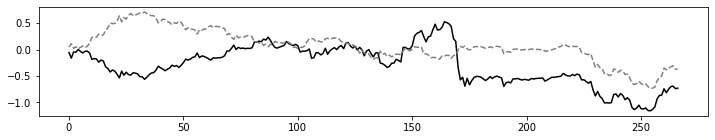

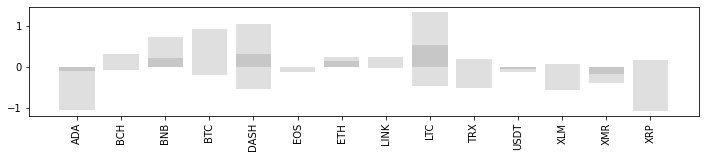

Episode 1/100 epsilon 0.92274469442792


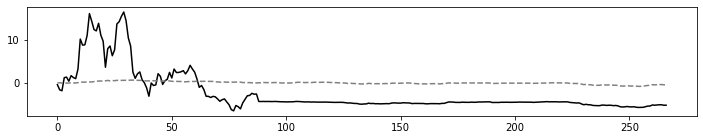

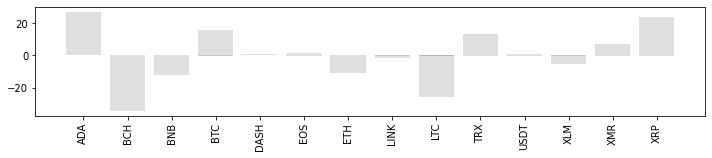

Episode 2/100 epsilon 0.92274469442792


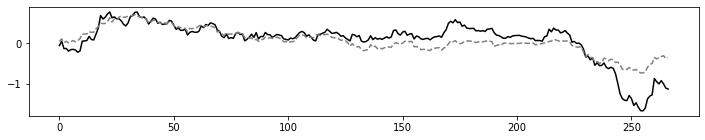

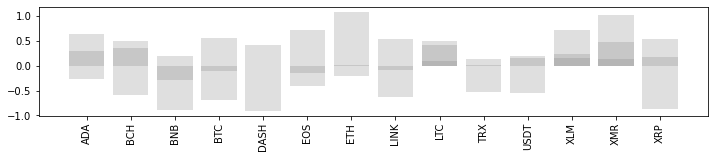

Episode 3/100 epsilon 0.92274469442792


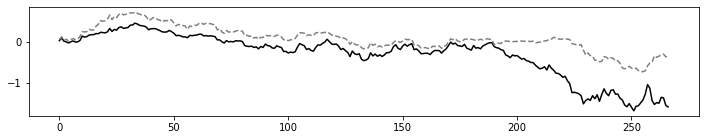

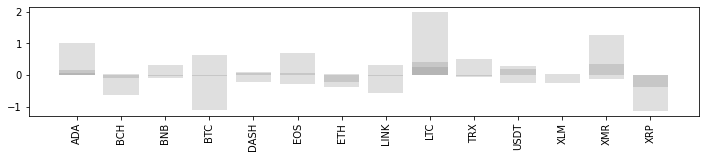

Episode 4/100 epsilon 0.92274469442792


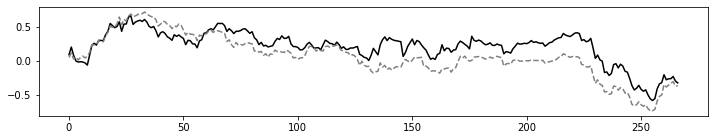

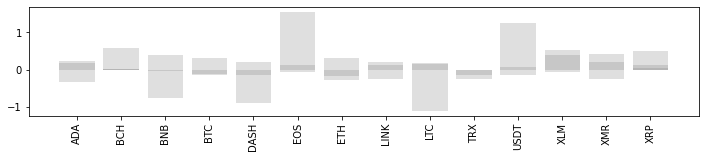

Episode 5/100 epsilon 0.92274469442792


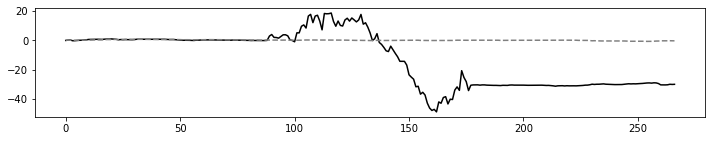

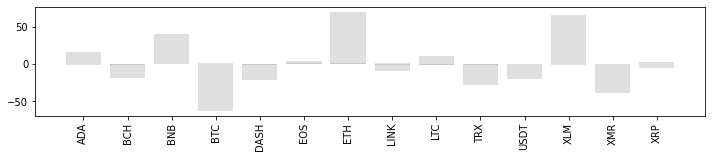

Episode 6/100 epsilon 0.92274469442792
1/1 [==============================] - 0s 13ms/step


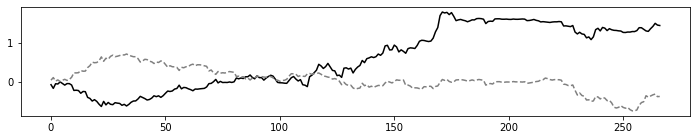

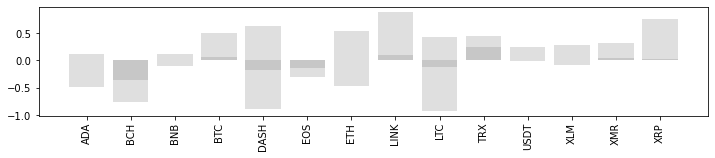

Episode 7/100 epsilon 0.92274469442792


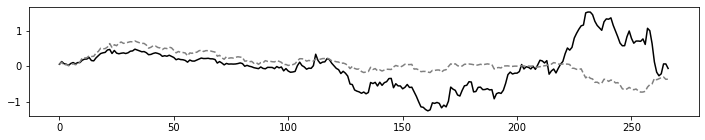

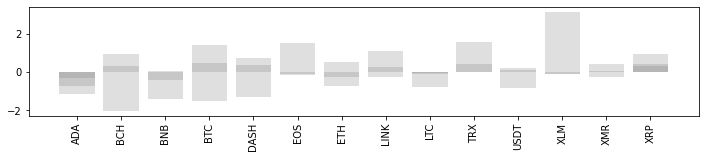

Episode 8/100 epsilon 0.92274469442792


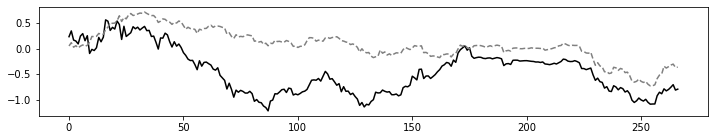

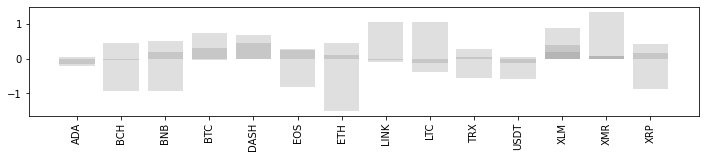

Episode 9/100 epsilon 0.92274469442792


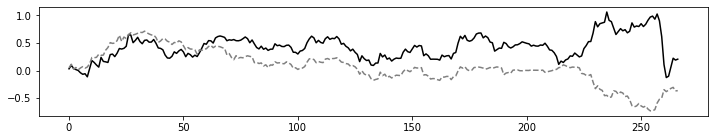

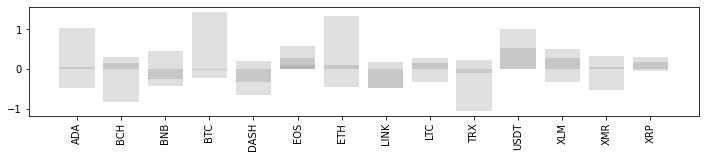

Episode 10/100 epsilon 0.92274469442792
1/1 [==============================] - 0s 11ms/step


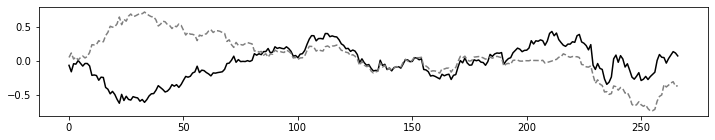

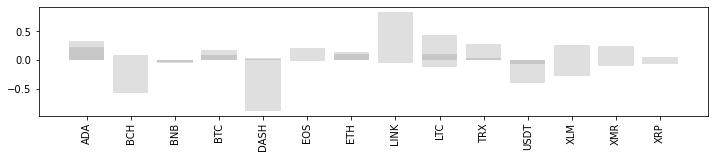

Episode 11/100 epsilon 0.9135172474836407
1/1 [==============================] - 0s 12ms/step


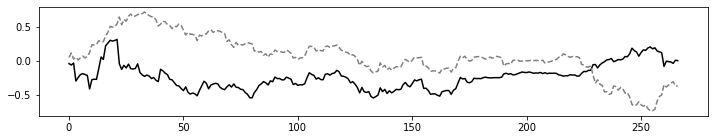

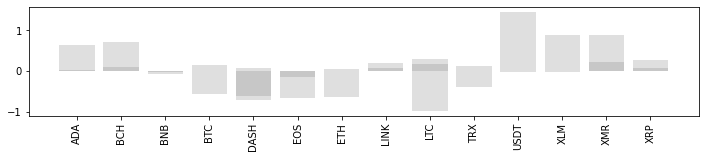

Episode 12/100 epsilon 0.9135172474836407


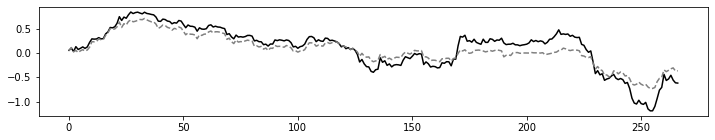

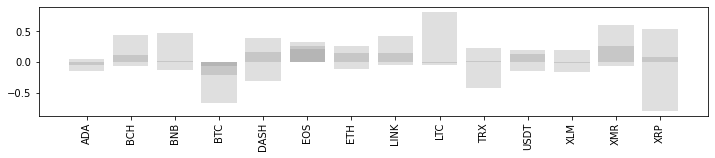

Episode 13/100 epsilon 0.9135172474836407


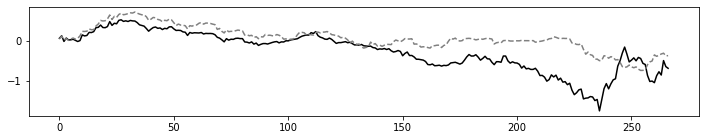

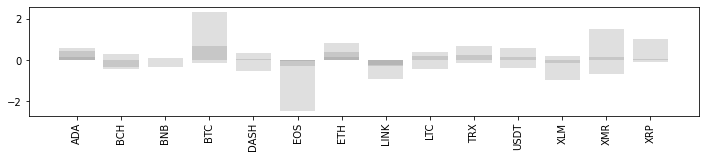

Episode 14/100 epsilon 0.9135172474836407


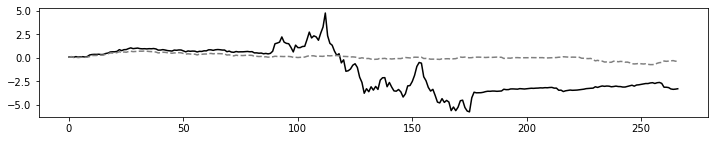

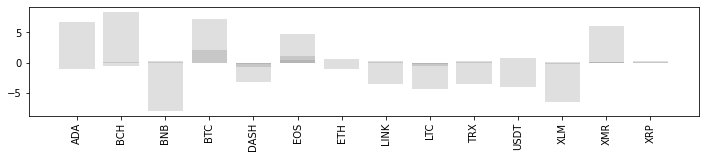

Episode 15/100 epsilon 0.9135172474836407
1/1 [==============================] - 0s 12ms/step


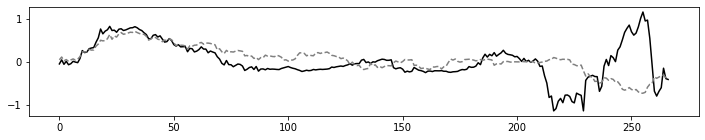

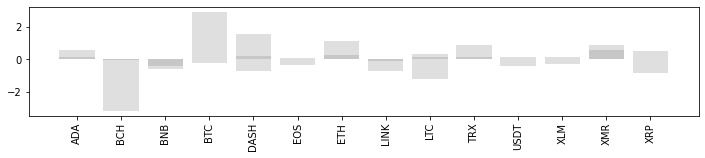

Episode 16/100 epsilon 0.9135172474836407
1/1 [==============================] - 0s 11ms/step


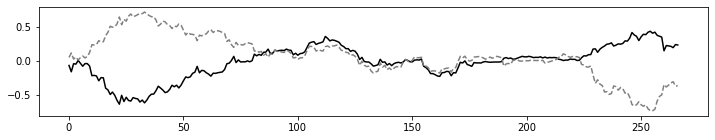

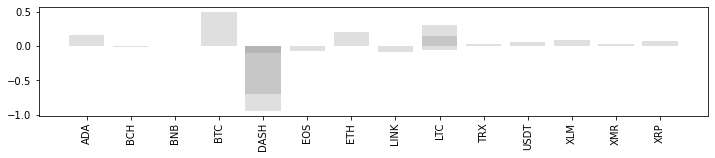

Episode 17/100 epsilon 0.9135172474836407
1/1 [==============================] - 0s 13ms/step


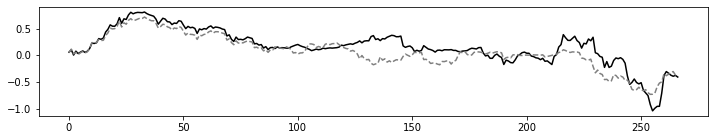

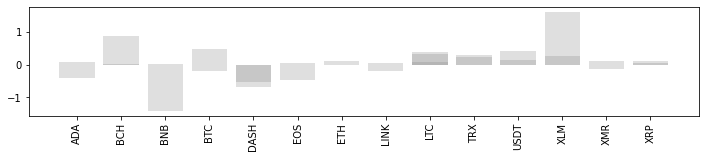

Episode 18/100 epsilon 0.9135172474836407


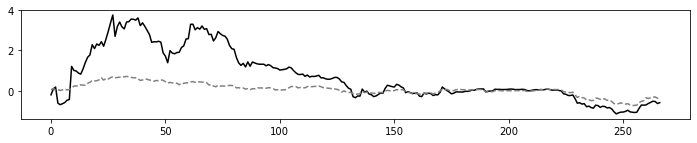

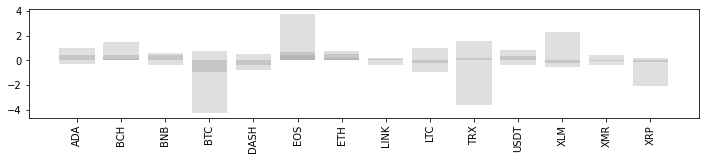

Episode 19/100 epsilon 0.9135172474836407


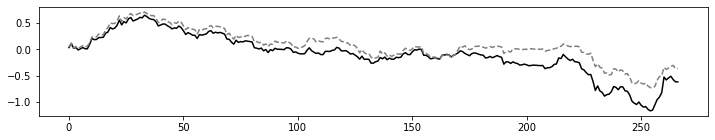

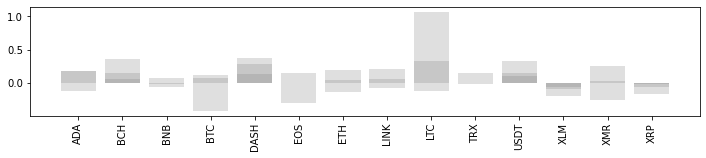

Episode 20/100 epsilon 0.9135172474836407


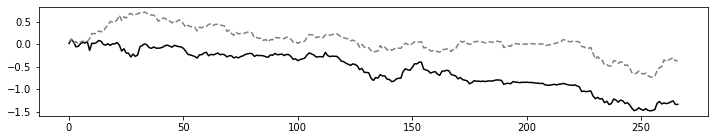

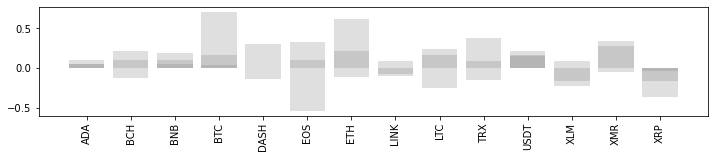

Episode 21/100 epsilon 0.9135172474836407
1/1 [==============================] - 0s 11ms/step


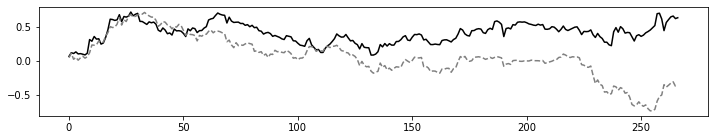

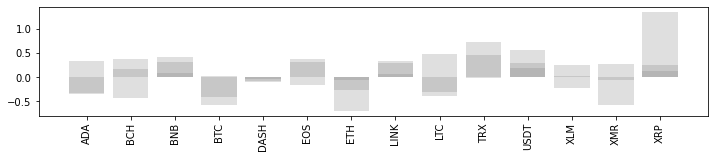

Episode 22/100 epsilon 0.9043820750088043


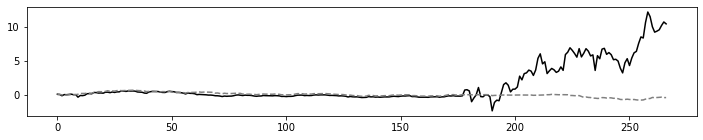

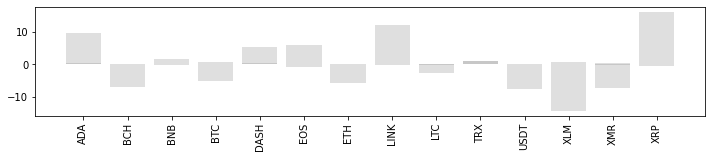

Episode 23/100 epsilon 0.9043820750088043


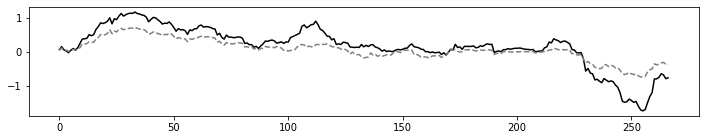

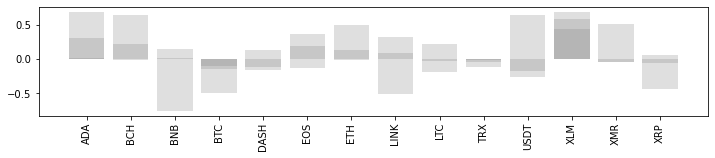

Episode 24/100 epsilon 0.9043820750088043


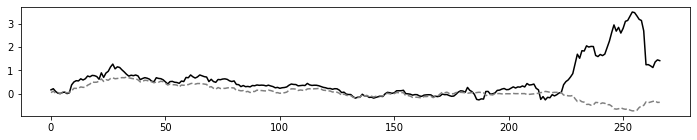

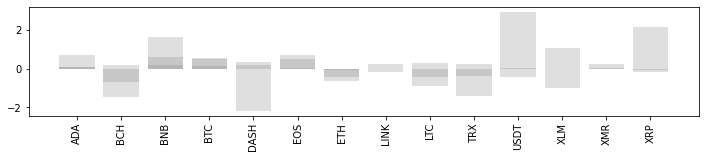

Episode 25/100 epsilon 0.9043820750088043
1/1 [==============================] - 0s 11ms/step


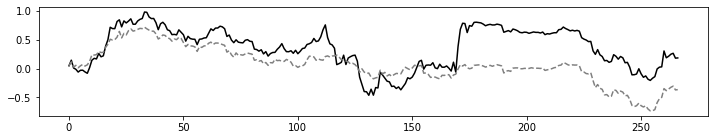

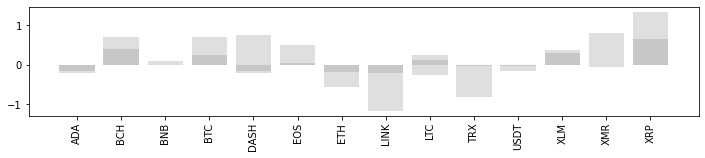

Episode 26/100 epsilon 0.9043820750088043


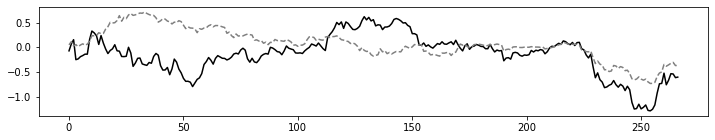

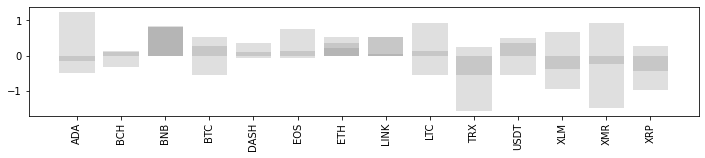

Episode 27/100 epsilon 0.9043820750088043
1/1 [==============================] - 0s 11ms/step


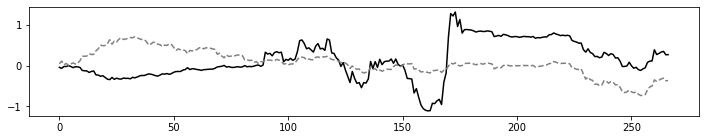

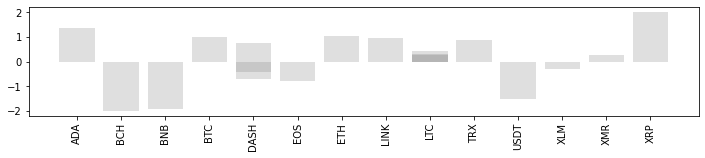

Episode 28/100 epsilon 0.9043820750088043


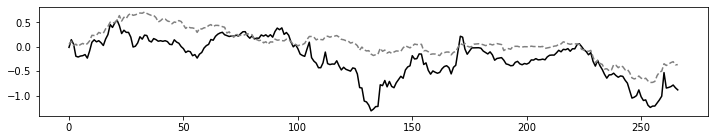

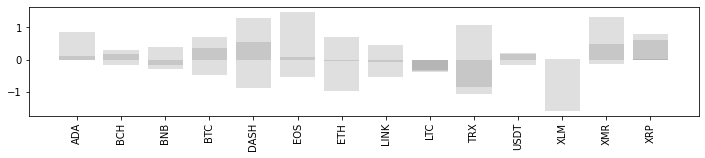

Episode 29/100 epsilon 0.9043820750088043


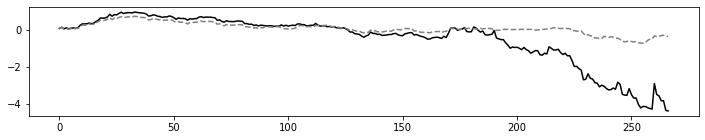

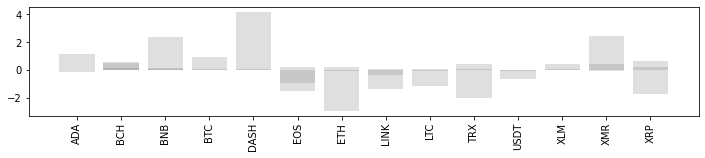

Episode 30/100 epsilon 0.9043820750088043


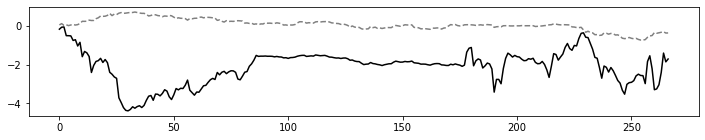

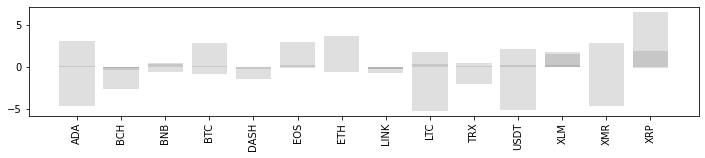

Episode 31/100 epsilon 0.9043820750088043


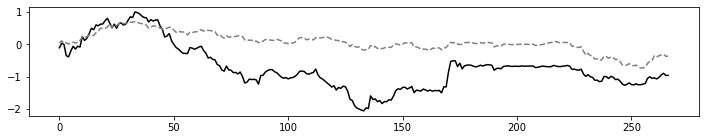

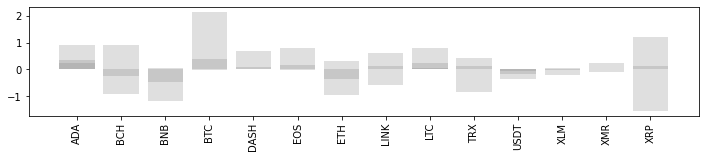

Episode 32/100 epsilon 0.9043820750088043
1/1 [==============================] - 0s 11ms/step


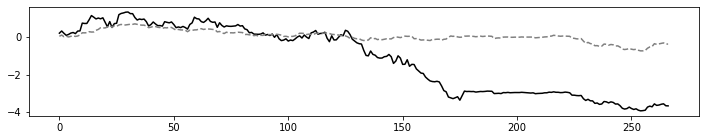

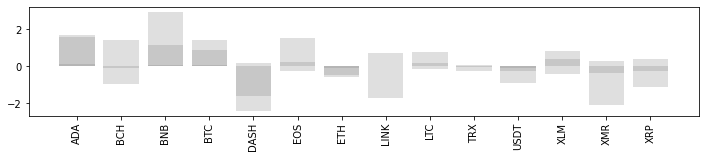

Episode 33/100 epsilon 0.8953382542587163


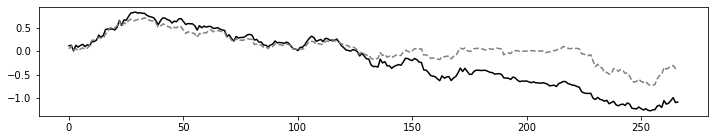

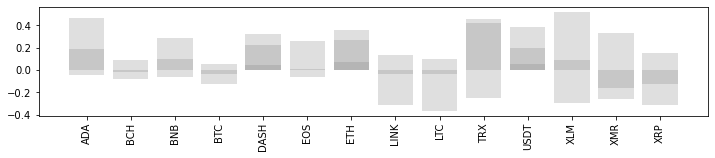

Episode 34/100 epsilon 0.8953382542587163


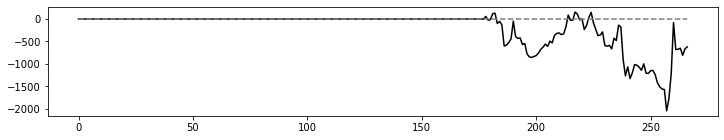

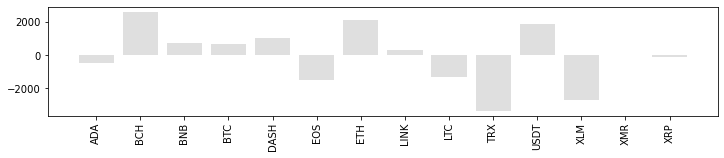

Episode 35/100 epsilon 0.8953382542587163


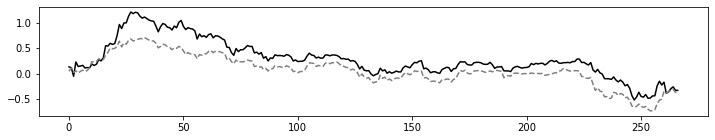

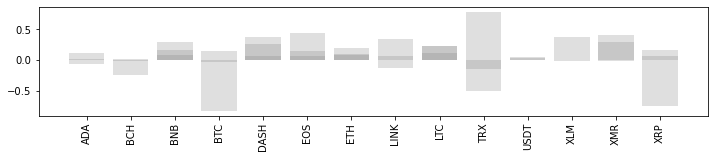

Episode 36/100 epsilon 0.8953382542587163


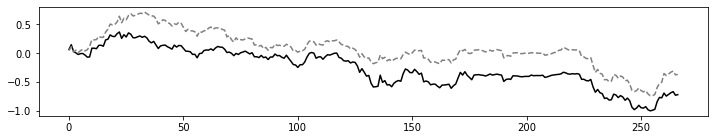

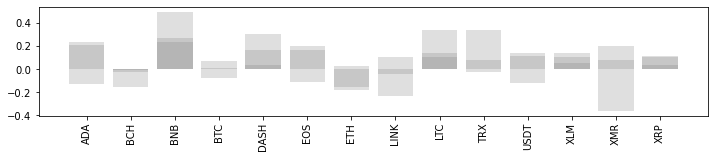

Episode 37/100 epsilon 0.8953382542587163


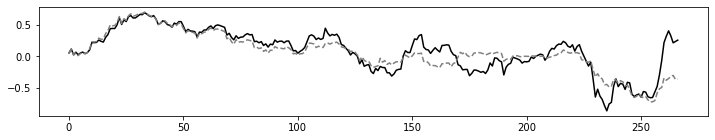

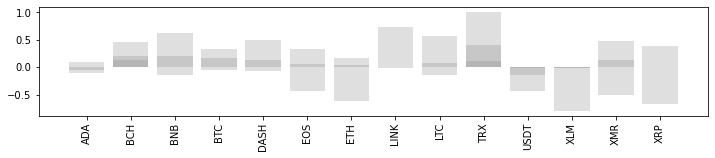

Episode 38/100 epsilon 0.8953382542587163


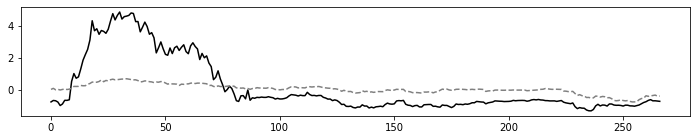

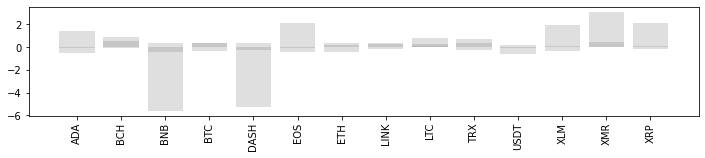

Episode 39/100 epsilon 0.8953382542587163


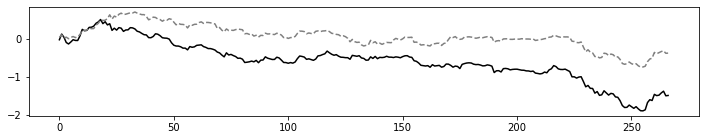

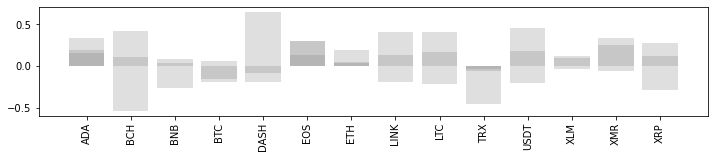

Episode 40/100 epsilon 0.8953382542587163


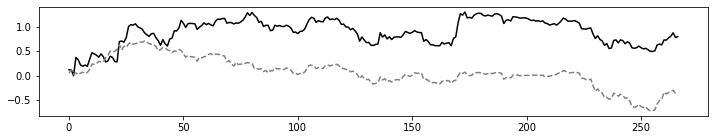

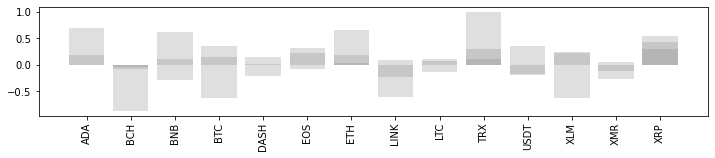

Episode 41/100 epsilon 0.8953382542587163


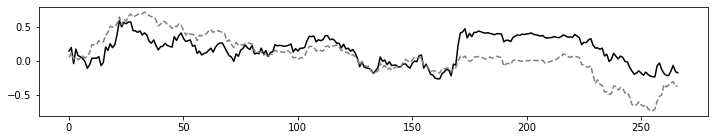

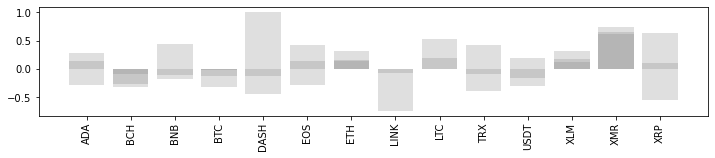

Episode 42/100 epsilon 0.8953382542587163
1/1 [==============================] - 0s 11ms/step


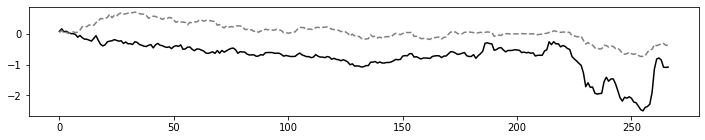

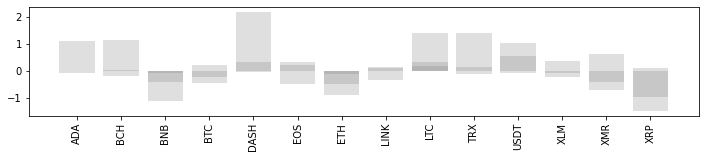

Episode 43/100 epsilon 0.8863848717161291


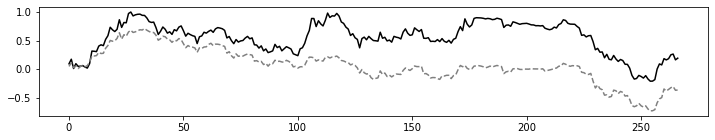

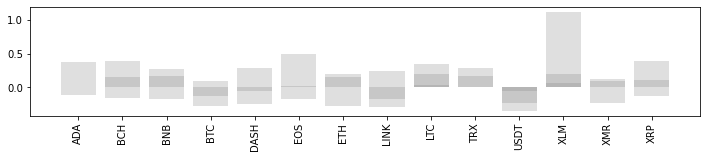

Episode 44/100 epsilon 0.8863848717161291


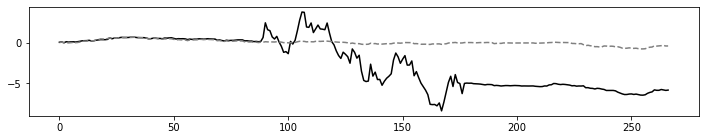

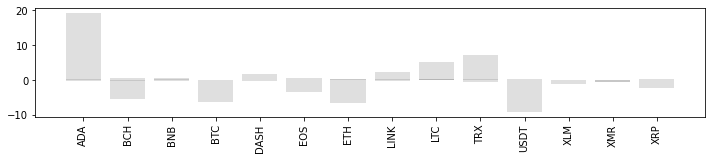

Episode 45/100 epsilon 0.8863848717161291
1/1 [==============================] - 0s 12ms/step


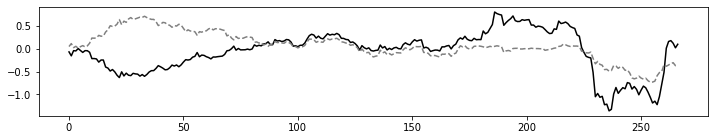

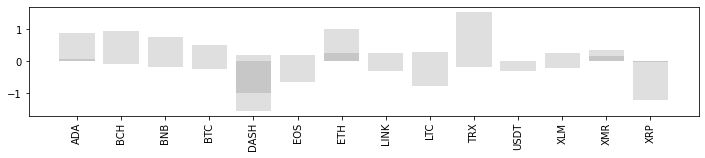

Episode 46/100 epsilon 0.8863848717161291


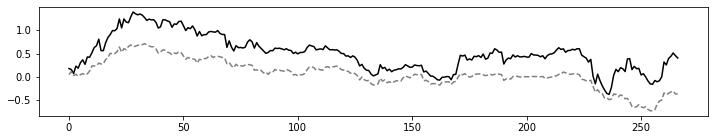

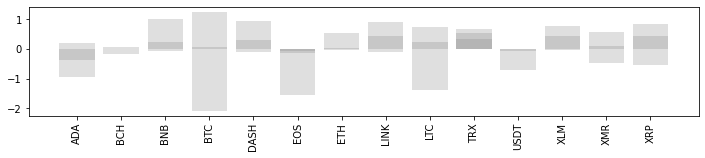

Episode 47/100 epsilon 0.8863848717161291


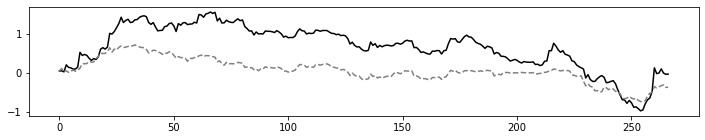

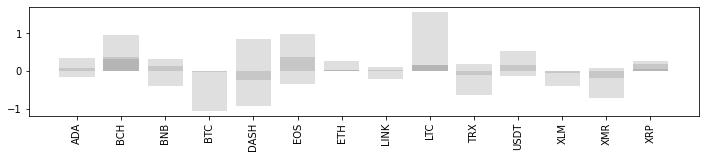

Episode 48/100 epsilon 0.8863848717161291


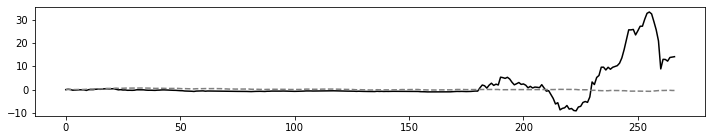

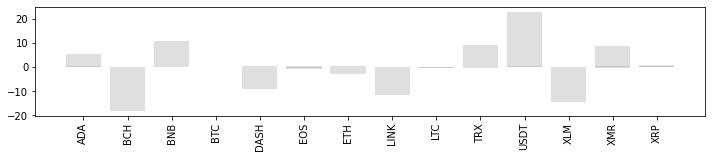

Episode 49/100 epsilon 0.8863848717161291


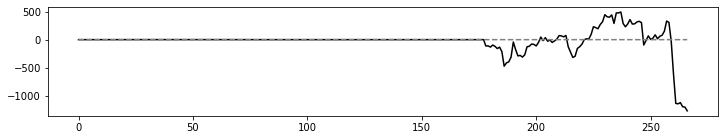

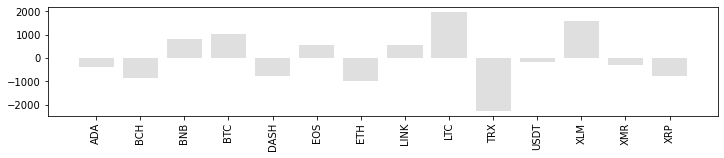

Episode 50/100 epsilon 0.8863848717161291


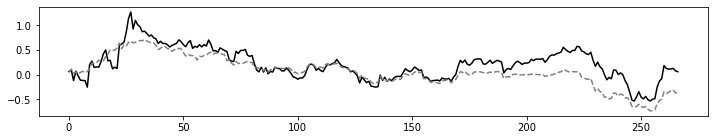

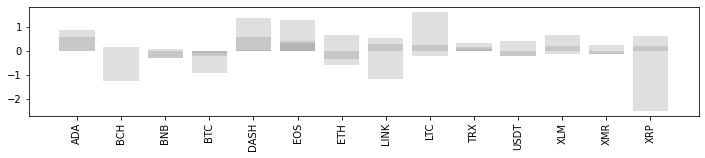

Episode 51/100 epsilon 0.8863848717161291


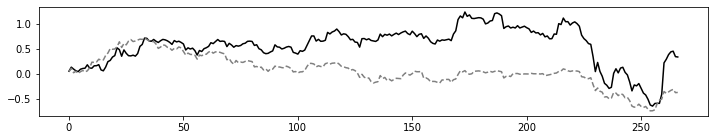

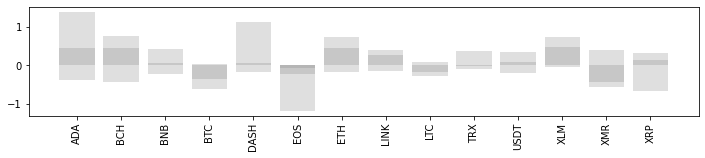

Episode 52/100 epsilon 0.8863848717161291


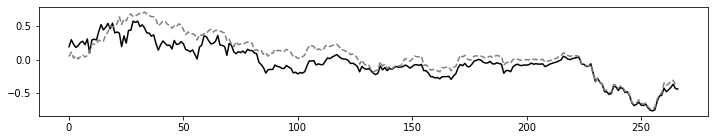

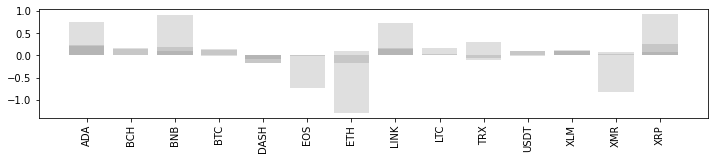

Episode 53/100 epsilon 0.8863848717161291
1/1 [==============================] - 0s 12ms/step


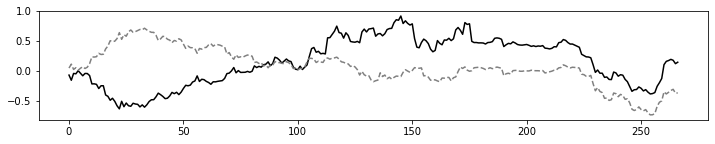

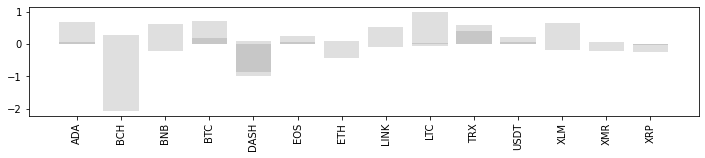

Episode 54/100 epsilon 0.8775210229989678


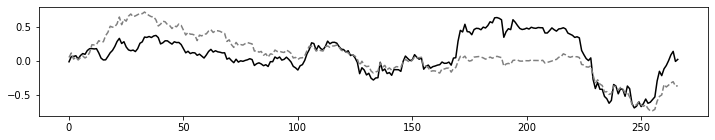

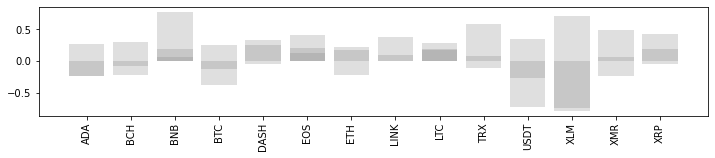

Episode 55/100 epsilon 0.8775210229989678
1/1 [==============================] - 0s 12ms/step


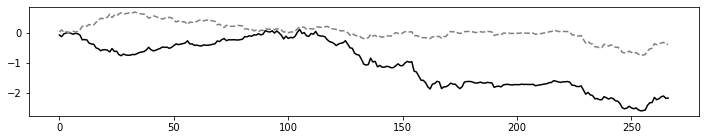

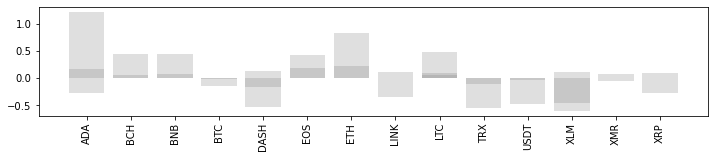

Episode 56/100 epsilon 0.8775210229989678
1/1 [==============================] - 0s 12ms/step


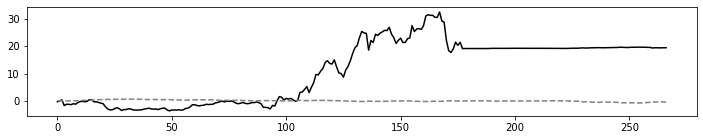

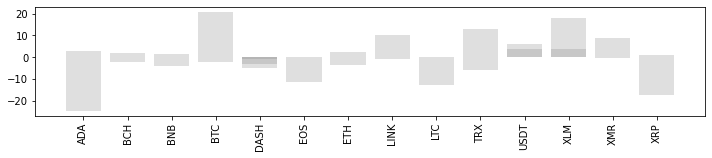

Episode 57/100 epsilon 0.8775210229989678
1/1 [==============================] - 0s 12ms/step


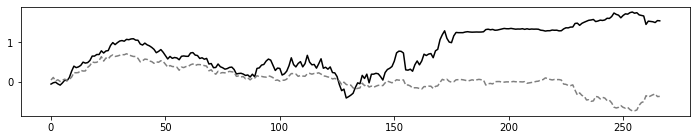

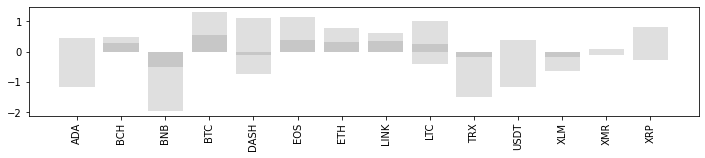

Episode 58/100 epsilon 0.8775210229989678


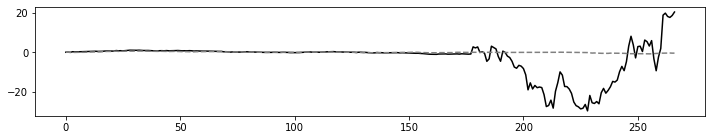

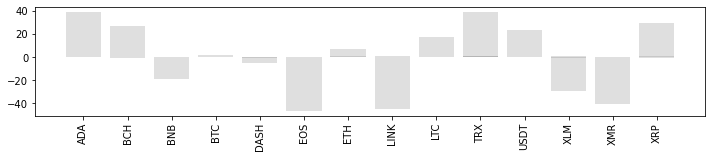

Episode 59/100 epsilon 0.8775210229989678
1/1 [==============================] - 0s 12ms/step


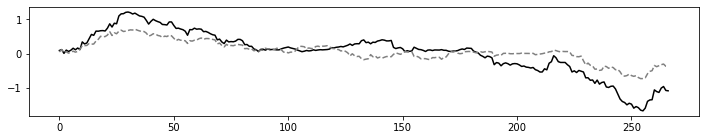

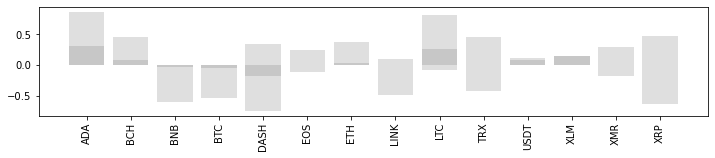

Episode 60/100 epsilon 0.8775210229989678


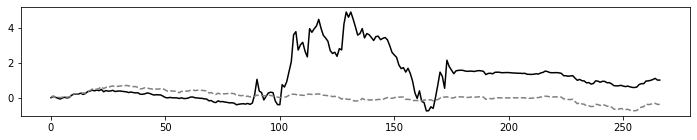

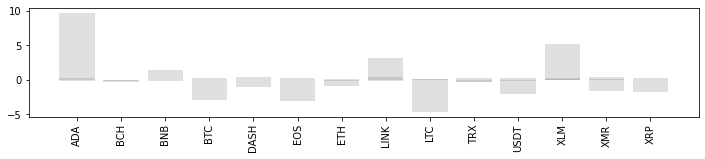

Episode 61/100 epsilon 0.8775210229989678


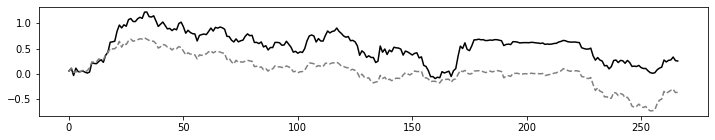

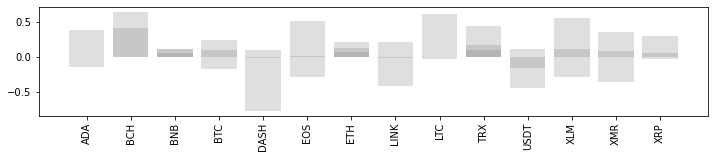

Episode 62/100 epsilon 0.8775210229989678


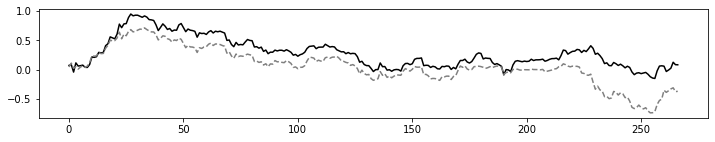

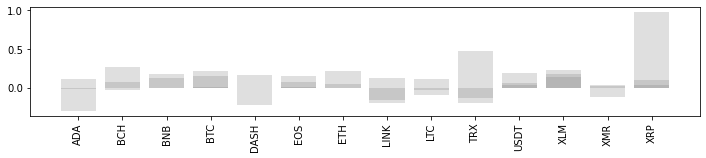

Episode 63/100 epsilon 0.8775210229989678
1/1 [==============================] - 0s 12ms/step


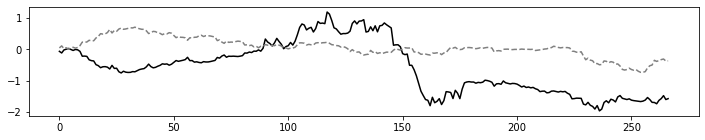

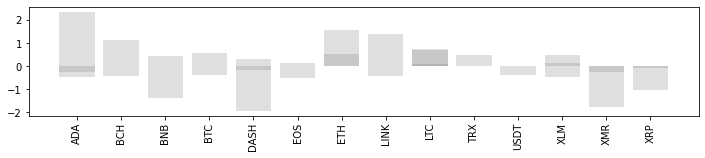

Episode 64/100 epsilon 0.8775210229989678
1/1 [==============================] - 0s 12ms/step


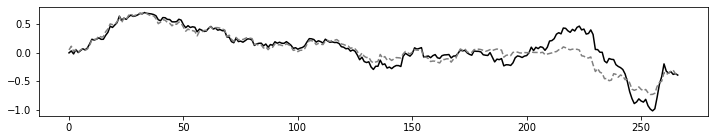

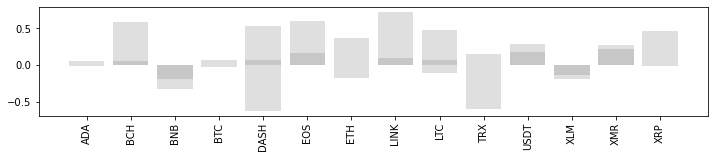

Episode 65/100 epsilon 0.8687458127689781
1/1 [==============================] - 0s 12ms/step


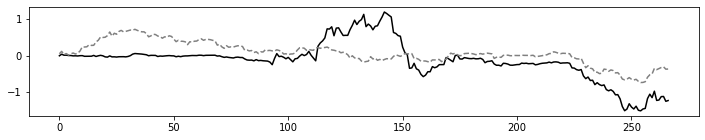

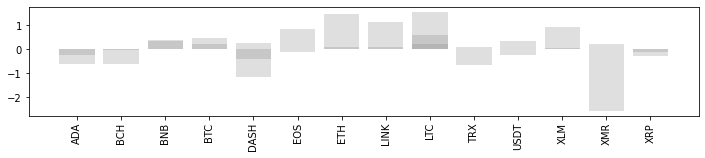

Episode 66/100 epsilon 0.8687458127689781


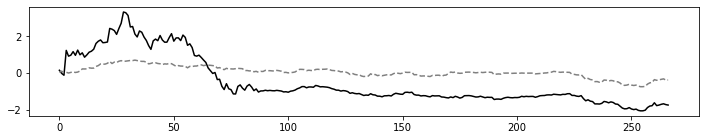

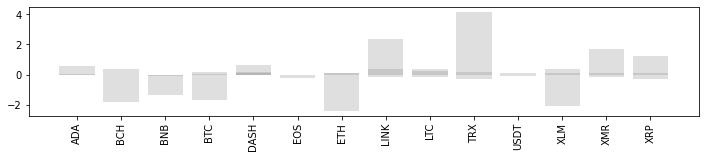

Episode 67/100 epsilon 0.8687458127689781
1/1 [==============================] - 0s 12ms/step


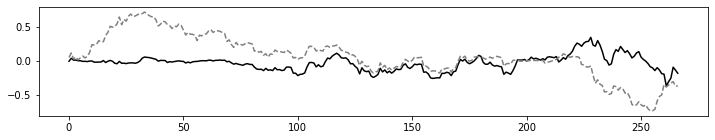

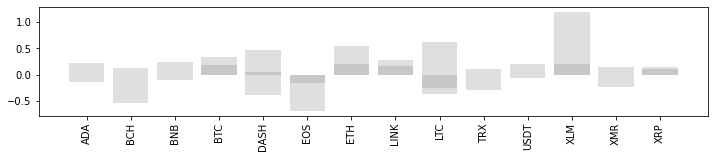

Episode 68/100 epsilon 0.8687458127689781


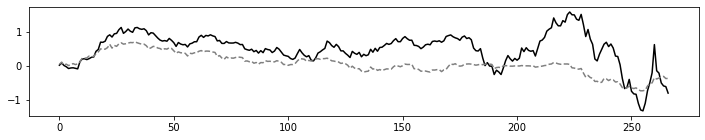

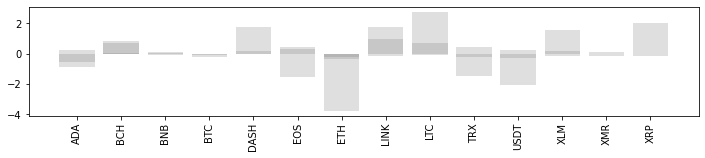

Episode 69/100 epsilon 0.8687458127689781


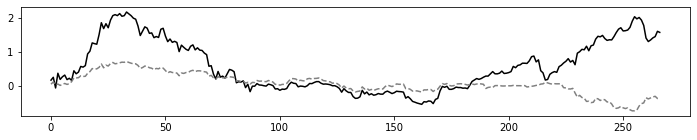

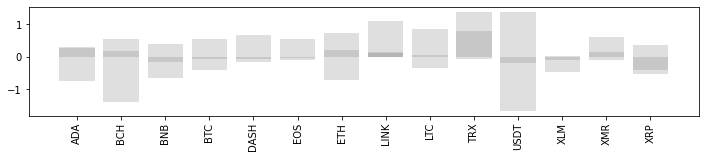

Episode 70/100 epsilon 0.8687458127689781


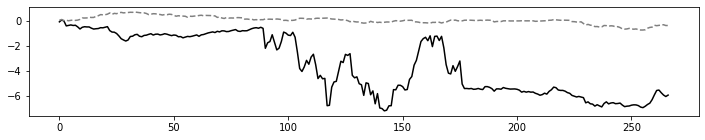

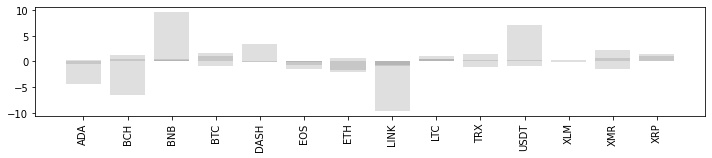

Episode 71/100 epsilon 0.8687458127689781
1/1 [==============================] - 0s 13ms/step


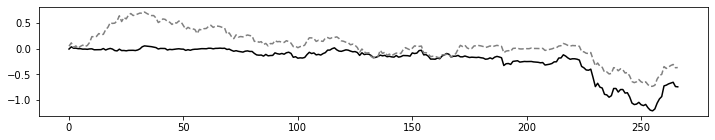

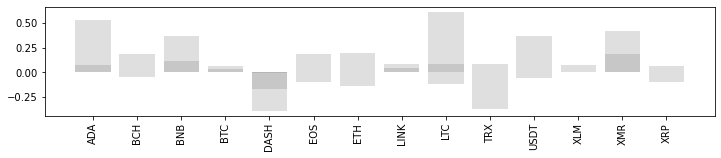

Episode 72/100 epsilon 0.8687458127689781
1/1 [==============================] - 0s 12ms/step


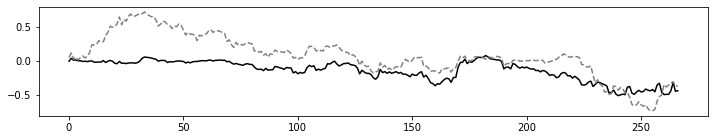

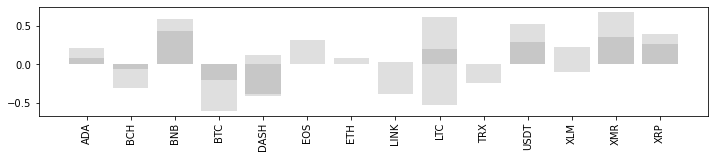

Episode 73/100 epsilon 0.8687458127689781


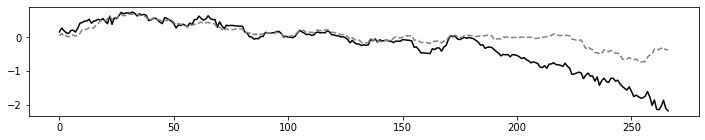

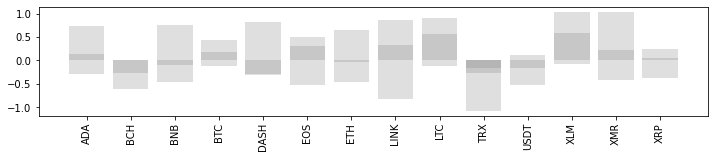

Episode 74/100 epsilon 0.8687458127689781
1/1 [==============================] - 0s 11ms/step


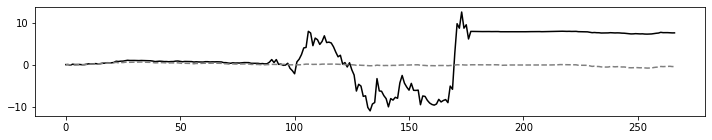

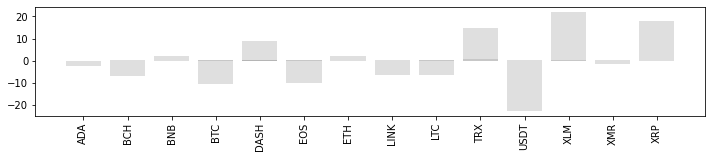

Episode 75/100 epsilon 0.8600583546412883
1/1 [==============================] - 0s 12ms/step


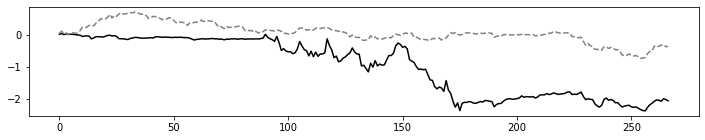

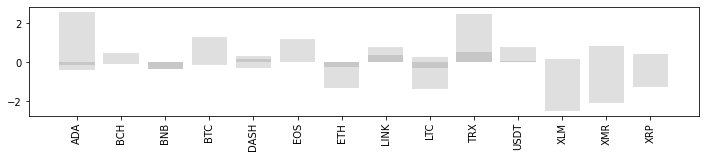

Episode 76/100 epsilon 0.8600583546412883
1/1 [==============================] - 0s 13ms/step


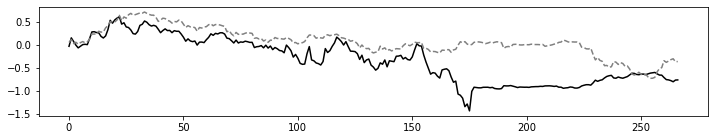

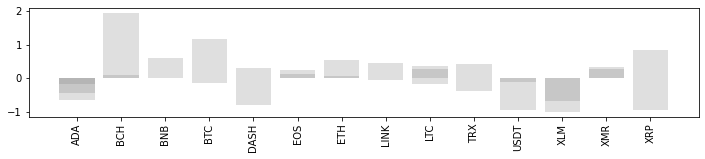

Episode 77/100 epsilon 0.8600583546412883
1/1 [==============================] - 0s 12ms/step


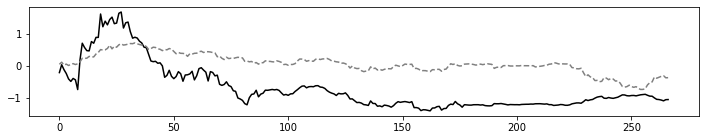

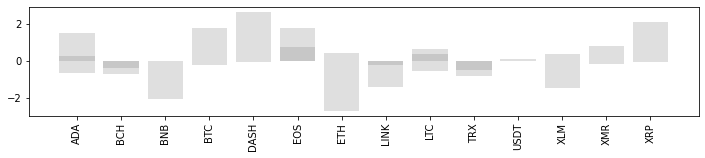

Episode 78/100 epsilon 0.8600583546412883


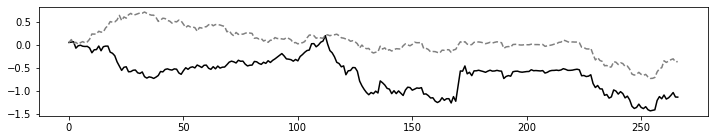

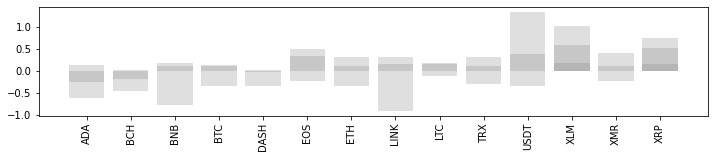

Episode 79/100 epsilon 0.8600583546412883
1/1 [==============================] - 0s 13ms/step


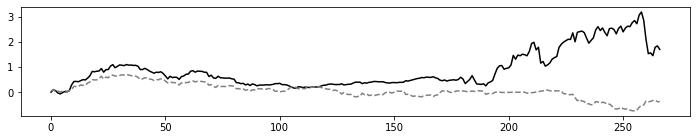

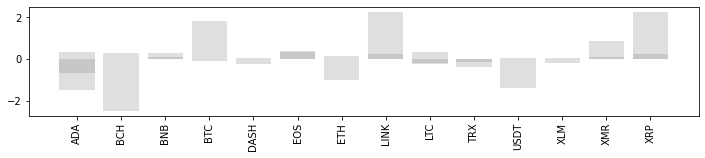

Episode 80/100 epsilon 0.8600583546412883
1/1 [==============================] - 0s 12ms/step


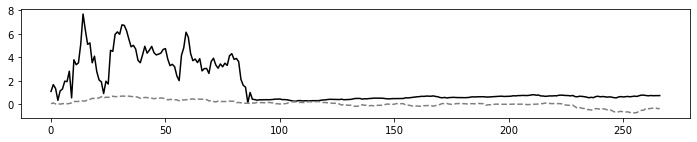

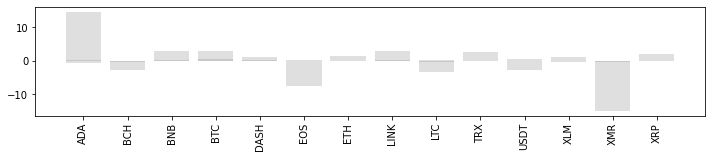

Episode 81/100 epsilon 0.8600583546412883


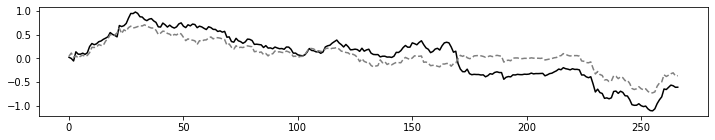

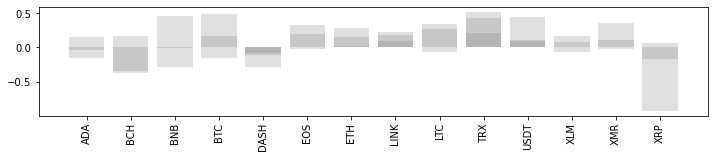

Episode 82/100 epsilon 0.8600583546412883
1/1 [==============================] - 0s 13ms/step


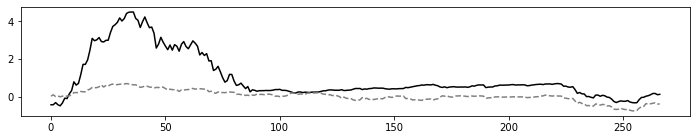

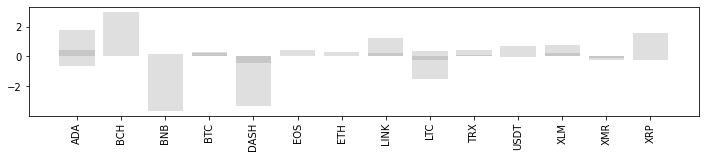

Episode 83/100 epsilon 0.8600583546412883


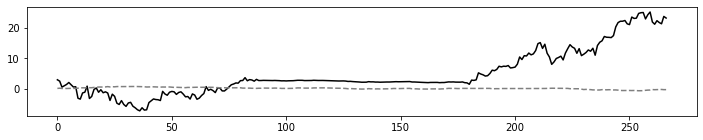

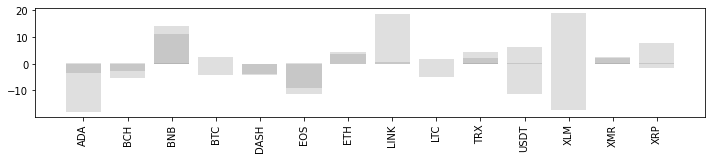

Episode 84/100 epsilon 0.8600583546412883


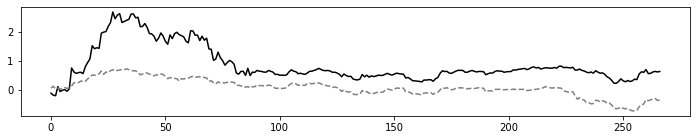

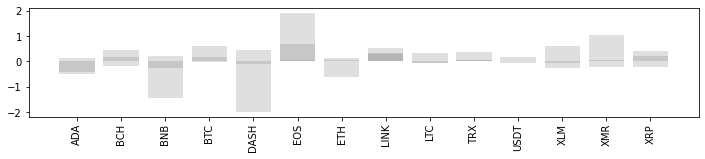

Episode 85/100 epsilon 0.8600583546412883
1/1 [==============================] - 0s 12ms/step


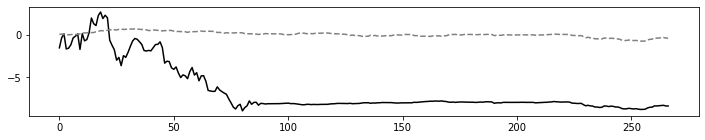

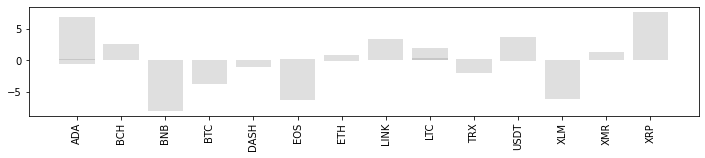

Episode 86/100 epsilon 0.8514577710948754


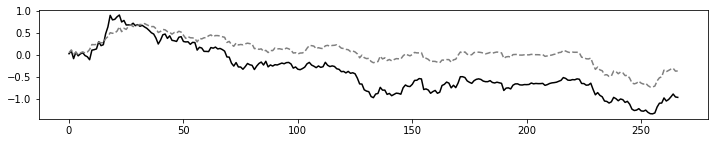

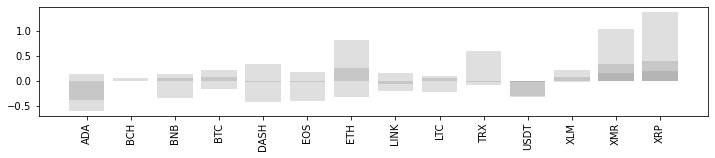

Episode 87/100 epsilon 0.8514577710948754


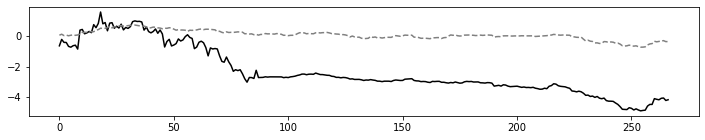

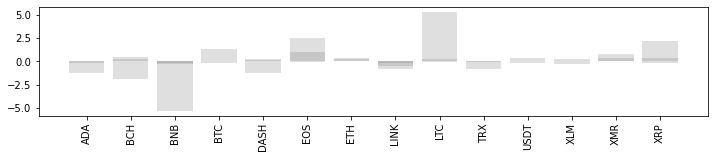

Episode 88/100 epsilon 0.8514577710948754
1/1 [==============================] - 0s 12ms/step


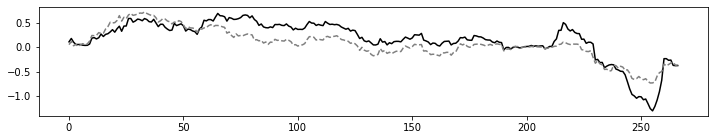

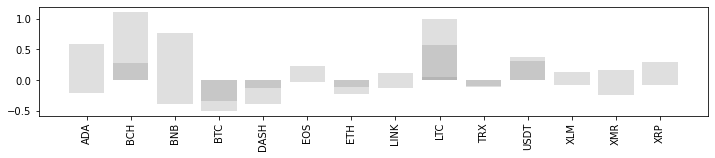

Episode 89/100 epsilon 0.8514577710948754


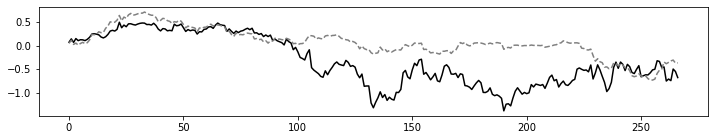

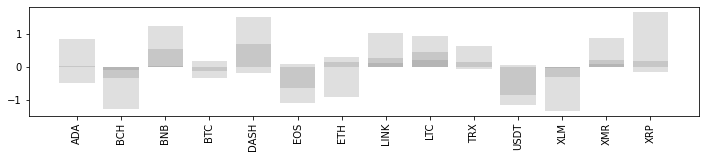

Episode 90/100 epsilon 0.8514577710948754


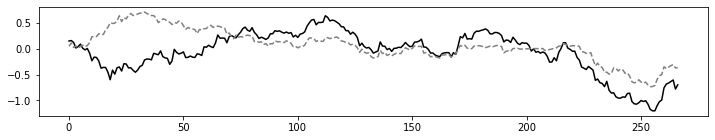

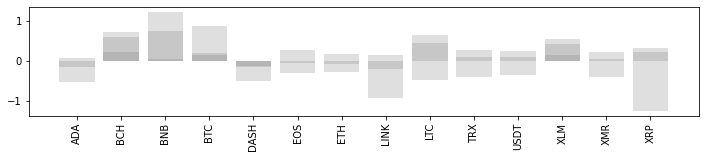

Episode 91/100 epsilon 0.8514577710948754
1/1 [==============================] - 0s 12ms/step


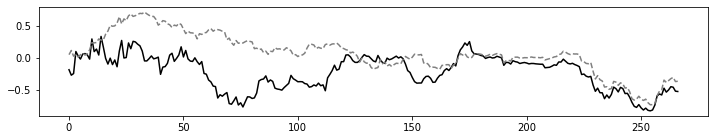

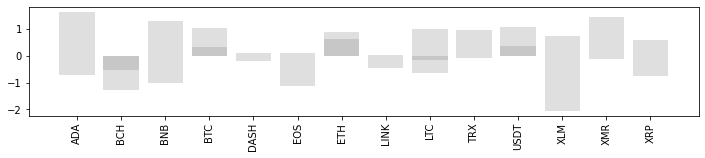

Episode 92/100 epsilon 0.8514577710948754


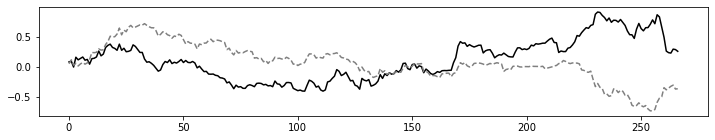

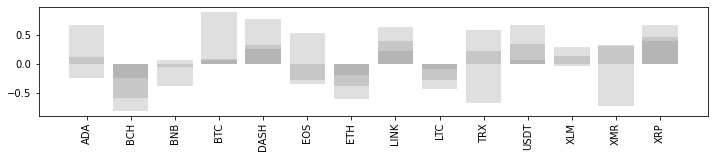

Episode 93/100 epsilon 0.8514577710948754


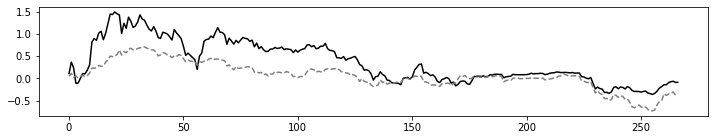

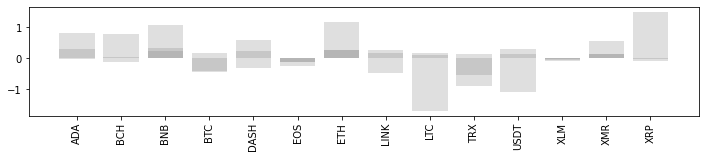

Episode 94/100 epsilon 0.8514577710948754
1/1 [==============================] - 0s 11ms/step


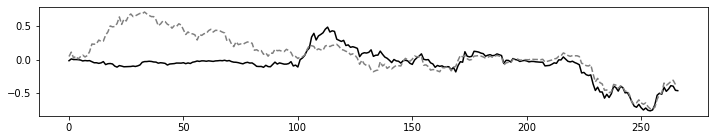

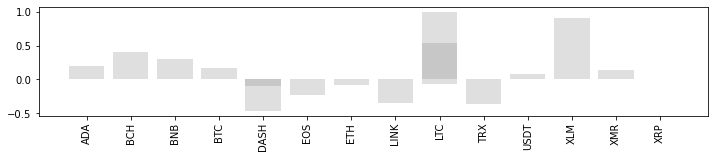

Episode 95/100 epsilon 0.8514577710948754
1/1 [==============================] - 0s 13ms/step


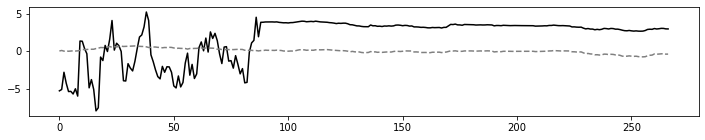

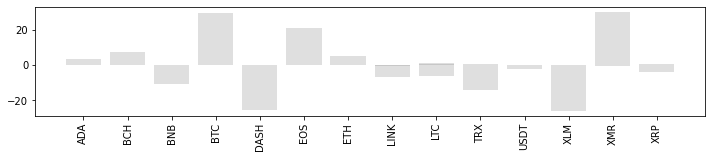

Episode 96/100 epsilon 0.8514577710948754
1/1 [==============================] - 0s 16ms/step


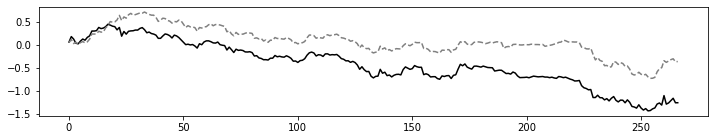

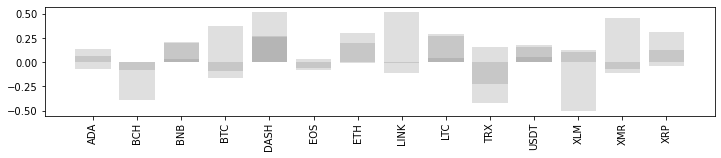

Episode 97/100 epsilon 0.8429431933839266
1/1 [==============================] - 0s 27ms/step


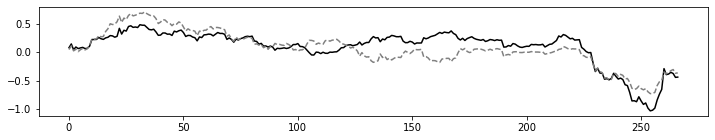

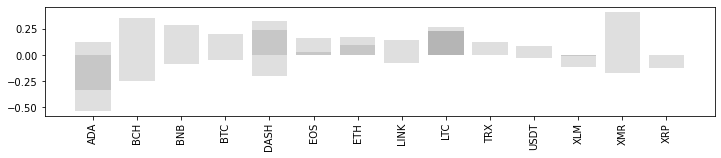

Episode 98/100 epsilon 0.8429431933839266
1/1 [==============================] - 0s 32ms/step


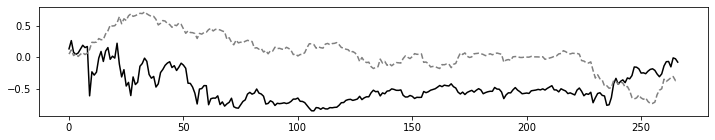

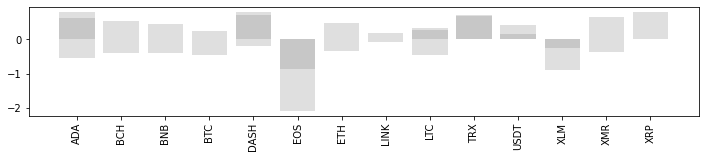

Episode 99/100 epsilon 0.8429431933839266


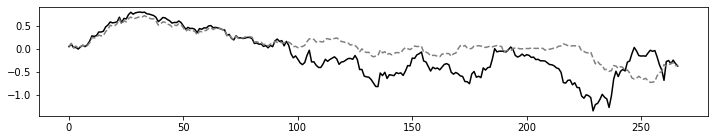

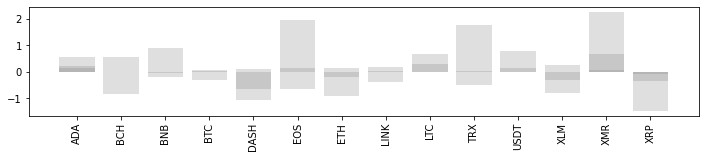

In [85]:
import matplotlib.pyplot as plt
import random

for e in range(episode_count):
    
    agent.is_eval = False
    data_length = len(env.data)
    
    returns_history = []
    returns_history_equal = []
    
    rewards_history = []
    equal_rewards = []
    
    actions_to_show = []
    
    print("Episode " + str(e) + "/" + str(episode_count), 'epsilon', agent.epsilon)

    s = env.get_state(np.random.randint(window_size+1, data_length-window_size-1), window_size)
    total_profit = 0 

    for t in range(window_size, data_length, rebalance_period):
        date1 = t-rebalance_period
        #correlation from 90-180 days 
        s_ = env.get_state(t, window_size)
        action = agent.act(s_)
        
        actions_to_show.append(action[0])
        
        weighted_returns, reward = env.get_reward(action[0], date1, t)
        weighted_returns_equal, reward_equal = env.get_reward(
            np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

        rewards_history.append(reward)
        equal_rewards.append(reward_equal)
        returns_history.extend(weighted_returns)
        returns_history_equal.extend(weighted_returns_equal)

        done = True if t == data_length else False
        agent.memory4replay.append((s, s_, action, reward, done))
        
        if len(agent.memory4replay) >= batch_size:
            agent.expReplay(batch_size)
            agent.memory4replay = []
            
        s = s_

    rl_result = np.array(returns_history).cumsum()
    equal_result = np.array(returns_history_equal).cumsum()

    plt.figure(figsize = (12, 2))
    plt.plot(rl_result, color = 'black', ls = '-')
    plt.plot(equal_result, color = 'grey', ls = '--')
    plt.show()
    
    plt.figure(figsize = (12, 2))
    for a in actions_to_show:    
        plt.bar(np.arange(N_ASSETS), a, color = 'grey', alpha = 0.25)
        plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')
    plt.show()

The code produces the final results along with two charts for each episode. The first chart shows the total cumulative return over time, while the second chart shows the percentage of each cryptocurrency in the portfolio.The black line shows the performance of the portfolio, and the dotted grey line shows the performance of the benchmark, which is an equally weighted portfolio of cryptocurrencies.

In the last episodes the agent is starting to learn from its training and discovering the optimal strategy. Overall returns are relatively stable and outperform the benchmark. However, the overall portfolio weights are still quite vol‐ atile due to the short time series and high volatility of the underlying cryptocurrency assets. Ideally, we would be able to increase the number of training episodes and the length of historical data to enhance the training performance.


### Testing the Data
After training the data, it is tested it against the test dataset.

In [86]:
agent.is_eval = True

actions_equal, actions_rl = [], []
result_equal, result_rl = [], []

for t in range(window_size, len(env.data), rebalance_period):

    date1 = t-rebalance_period
    s_ = env.get_state(t, window_size)
    action = agent.act(s_)

    weighted_returns, reward = env.get_reward(action[0], date1, t)
    weighted_returns_equal, reward_equal = env.get_reward(
        np.ones(agent.portfolio_size) / agent.portfolio_size, date1, t)

    result_equal.append(weighted_returns_equal.tolist())
    actions_equal.append(np.ones(agent.portfolio_size) / agent.portfolio_size)
    
    result_rl.append(weighted_returns.tolist())
    actions_rl.append(action[0])

1/1 [==============================] - 0s 18ms/step


In [87]:
result_equal_vis = [item for sublist in result_equal for item in sublist]
result_rl_vis = [item for sublist in result_rl for item in sublist]

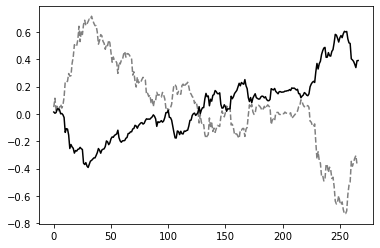

In [88]:
plt.figure()
plt.plot(np.array(result_equal_vis).cumsum(), label = 'Benchmark', color = 'grey',ls = '--')
plt.plot(np.array(result_rl_vis).cumsum(), label = 'Deep RL portfolio', color = 'black',ls = '-')
plt.show()

Despite underperforming during the initial period, the model performance was better overall, primarily due to avoiding the steep decline that the benchmark portfolio experienced in the latter part of the test window. The returns appear very stable, perhaps due to rotating away from the most volatile cryptocurrencies.

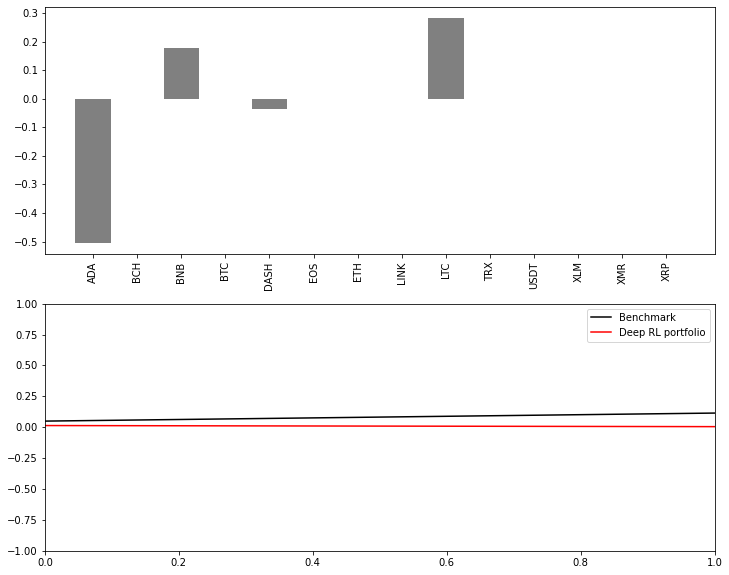

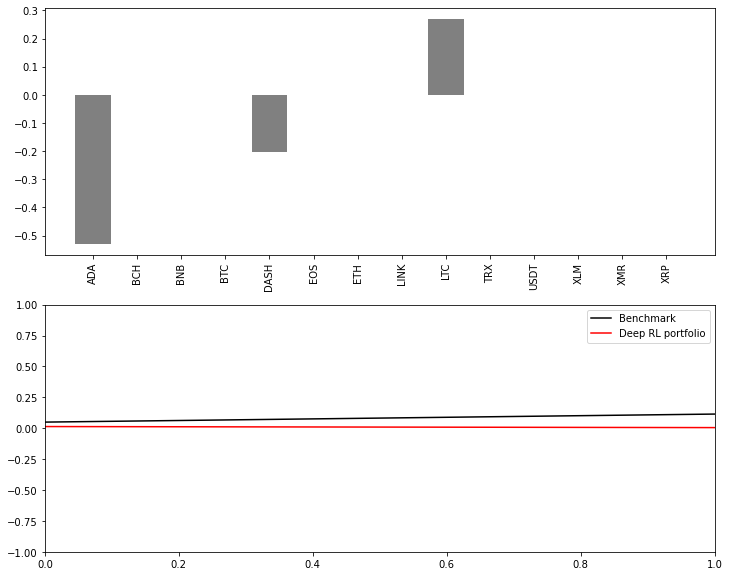

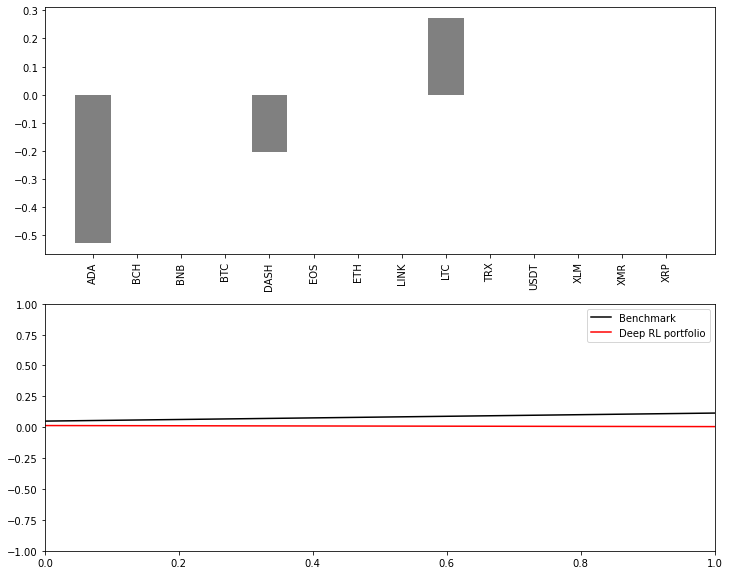

In [90]:
#Plotting the data
import matplotlib

N = len(np.array([item for sublist in result_equal for item in sublist]).cumsum()) 

for i in range(0, len(actions_rl)):
    current_range = np.arange(0, N)
    current_ts = np.zeros(N)
    current_ts2 = np.zeros(N)

    ts_benchmark = np.array([item for sublist in result_equal[:i+1] for item in sublist]).cumsum()
    ts_target = np.array([item for sublist in result_rl[:i+1] for item in sublist]).cumsum()

    t = len(ts_benchmark)
    current_ts[:t] = ts_benchmark
    current_ts2[:t] = ts_target

    current_ts[current_ts == 0] = ts_benchmark[-1]
    current_ts2[current_ts2 == 0] = ts_target[-1]

    plt.figure(figsize = (12, 10))

    plt.subplot(2, 1, 1)
    plt.bar(np.arange(N_ASSETS), actions_rl[i], color = 'grey')
    plt.xticks(np.arange(N_ASSETS), env.data.columns, rotation='vertical')

    plt.subplot(2, 1, 2)
    plt.plot(current_range[:t], current_ts[:t], color = 'black', label = 'Benchmark')
    plt.plot(current_range[:t], current_ts2[:t], color = 'red', label = 'Deep RL portfolio')
    plt.plot(current_range[t:], current_ts[t:], ls = '--', lw = .1, color = 'black')
    plt.autoscale(False)
    plt.ylim([-1, 1])
    plt.legend()

Let us inspect the return, volatility, Sharpe ratio, alpha, and beta of the portfolio and benchmark.

In [91]:
import statsmodels.api as sm
from statsmodels import regression
def sharpe(R):
    r = np.diff(R)
    sr = r.mean()/r.std() * np.sqrt(252)
    return sr

def print_stats(result, benchmark):

    sharpe_ratio = sharpe(np.array(result).cumsum())
    returns = np.mean(np.array(result))
    volatility = np.std(np.array(result))
    
    X = benchmark
    y = result
    x = sm.add_constant(X)
    model = regression.linear_model.OLS(y, x).fit()    
    alpha = model.params[0]
    beta = model.params[1]
    
    return np.round(np.array([returns, volatility, sharpe_ratio, alpha, beta]), 4).tolist()

In [104]:
print('       returns volat. sharp_rat alpha beta')
print('EQUAL', print_stats(result_equal_vis, result_equal_vis))
print('RL AGENT', print_stats(result_rl_vis, result_equal_vis))

       returns volat. sharp_rat alpha beta
EQUAL [-0.0014, 0.045, -0.5505, -0.0, 1.0]
RL AGENT [0.0015, 0.0281, 0.7983, 0.0008, -0.4892]


RL portfolio has a higher return, higher sharp, lower volatility, higher alpha and negative correlation with the benchmark.

The trained RL-based model outperformed an equal-weight benchmark in the test set. The performance of the RL-based model can be further improved by optimizing the hyperparameters or using a longer time series for training. However, given the high complexity and low interpretability of an RL-based model, testing should occur across different time periods and market cycles before deploying the model for live trading. 